<a href="https://colab.research.google.com/github/jihyun923/city_change/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%writefile "/content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/launcher.py"

import os, sys, math, argparse, glob
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import rasterio

# ----------------------------
# 유틸
# ----------------------------
def detect_scale(arr):
    a = np.nanpercentile(arr, 99.9)
    if a <= 1.0 + 1e-6:
        return 1.0
    if a <= 255 + 5:
        return 255.0
    return 10000.0


def to_onehot(lbl, num_classes, ignore_index=255):
    b, h, w = lbl.shape
    oh = torch.zeros(b, num_classes, h, w, device=lbl.device, dtype=torch.float32)
    mask = (lbl != ignore_index)
    idx = lbl.clone()
    idx[~mask] = 0
    oh.scatter_(1, idx.unsqueeze(1), 1.0)
    oh *= mask.unsqueeze(1)
    return oh


# ----------------------------
# 데이터셋
# ----------------------------
class LandCoverDataset(Dataset):
    def __init__(self, image_dir, mask_dir, class_mapping=None, in_channels=None, ignore_label=255):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.ignore_label = ignore_label
        self.class_mapping = class_mapping
        self.in_channels = in_channels

        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.tif', '.tiff', '.png', '.jpg'))
        ])
        if len(self.images) == 0:
            raise RuntimeError(f"No images found in {image_dir}")

        self.mask_exts = ('.tif', '.tiff', '.png', '.jpg')

    def __len__(self):
        return len(self.images)

    def _find_mask(self, base):
        for e in self.mask_exts:
            p = os.path.join(self.mask_dir, base + e)
            if os.path.exists(p):
                return p
        raise FileNotFoundError(f"Mask not found for {base}")

    def __getitem__(self, idx):
        name = self.images[idx]
        base = os.path.splitext(name)[0]

        img_p = os.path.join(self.image_dir, name)
        with rasterio.open(img_p) as src:
            img = src.read().astype(np.float32)  # (C,H,W)
        C, H, W = img.shape

        if self.in_channels is not None:
            if self.in_channels <= C:
                img = img[:self.in_channels]
            else:
                pad = self.in_channels - C
                img = np.concatenate(
                    [img, np.zeros((pad, H, W), dtype=np.float32)], axis=0
                )

        img = img / (detect_scale(img) + 1e-6)
        img = torch.from_numpy(img)

        # mask
        msk_p = self._find_mask(base)
        with rasterio.open(msk_p) as src:
            msk = src.read(1).astype(np.int64)

        if self.class_mapping is None:
            mapped = torch.from_numpy(msk).long()
        else:
            mapped_np = np.full_like(msk, self.ignore_label, dtype=np.int64)
            for k, v in self.class_mapping.items():
                mapped_np[msk == k] = v
            mapped = torch.from_numpy(mapped_np).long()

        return img, mapped


# ----------------------------
# 모델
# ----------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self, in_channels=4, num_classes=4):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128);        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256);       self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512);       self.pool4 = nn.MaxPool2d(2)

        self.bot  = DoubleConv(512, 1024)

        self.up4  = nn.ConvTranspose2d(1024, 512, 2, 2); self.dec4 = DoubleConv(1024, 512)
        self.up3  = nn.ConvTranspose2d(512, 256, 2, 2);  self.dec3 = DoubleConv(512, 256)
        self.up2  = nn.ConvTranspose2d(256, 128, 2, 2);  self.dec2 = DoubleConv(256, 128)
        self.up1  = nn.ConvTranspose2d(128, 64, 2, 2);   self.dec1 = DoubleConv(128, 64)

        self.out  = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b  = self.bot(self.pool4(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out(d1)


# ----------------------------
# Dice Loss (안정 버전)
# ----------------------------
class SoftDiceLoss(nn.Module):
    def __init__(self, num_classes, ignore_index=255, smooth=1e-6):
        super().__init__()
        self.C = num_classes
        self.ignore = ignore_index
        self.smooth = smooth

    def forward(self, logits, target):
        probs = torch.softmax(logits, dim=1)
        onehot = to_onehot(target, self.C, ignore_index=self.ignore)

        valid = (target != self.ignore).float().unsqueeze(1)

        probs = probs * valid
        onehot = onehot * valid

        dims = (0, 2, 3)
        inter = torch.sum(probs * onehot, dims)
        denom = torch.sum(probs + onehot, dims)

        dice = (2 * inter + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()


# ----------------------------
# train
# ----------------------------
def train_one_epoch(model, loader, ce, dice, optimizer, device, amp, scaler):
    model.train()
    run = 0.0

    for x, y in tqdm(loader, desc="Train"):
        x, y = x.to(device), y.to(device).long()

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=amp):
            logits = model(x)
            loss = ce(logits, y)
            if dice is not None:
                loss = loss + dice(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        run += loss.item()

    return run / len(loader)


# ----------------------------
# validate
# ----------------------------
@torch.no_grad()
def validate(model, loader, ce, dice, device):
    model.eval()
    run = 0.0
    for x, y in tqdm(loader, desc="Val"):
        x, y = x.to(device), y.to(device).long()
        logits = model(x)
        loss = ce(logits, y)
        if dice is not None:
            loss = loss + dice(logits, y)
        run += loss.item()

    return run / len(loader)


# ----------------------------
# main
# ----------------------------
def parse_args():
    a = argparse.ArgumentParser()
    a.add_argument("--train_images", required=True)
    a.add_argument("--train_masks", required=True)
    a.add_argument("--val_images")
    a.add_argument("--val_masks")

    a.add_argument("--in_channels", type=int, default=None)
    a.add_argument("--ignore_label", type=int, default=255)

    a.add_argument("--epochs", type=int, default=50)
    a.add_argument("--batch_size", type=int, default=4)
    a.add_argument("--lr", type=float, default=1e-4)
    a.add_argument("--workers", type=int, default=2)

    a.add_argument("--mixed_precision", action="store_true")
    a.add_argument("--use_dice", action="store_true")
    a.add_argument("--weights_out", default="weights/best_unet.pth")
    return a.parse_args()


def scan_label_set(mask_root, ignore_label=255, exts=('.tif', '.tiff', '.png', '.jpg')):
    vals = set()
    for p in glob.glob(os.path.join(mask_root, "**", "*"), recursive=True):
        if os.path.isfile(p) and p.lower().endswith(exts):
            with rasterio.open(p) as src:
                a = src.read(1)
            vals.update(np.unique(a).tolist())

    return sorted([v for v in vals if v != ignore_label])


def main():
    args = parse_args()
    os.makedirs(os.path.dirname(args.weights_out) or ".", exist_ok=True)

    # scan labels
    label_set = scan_label_set(args.train_masks, ignore_label=args.ignore_label)
    if len(label_set) == 0:
        raise RuntimeError("No valid labels found in masks.")
    class_mapping = {v: i for i, v in enumerate(label_set)}
    num_classes = len(label_set)

    print(f"[INFO] Train labels = {label_set} → num_classes = {num_classes}")

    # dataset
    tr = LandCoverDataset(args.train_images, args.train_masks,
                          class_mapping=class_mapping,
                          in_channels=args.in_channels,
                          ignore_label=args.ignore_label)

    train_loader = DataLoader(tr, batch_size=args.batch_size, shuffle=True,
                              num_workers=args.workers, pin_memory=True)

    val_loader = None
    if args.val_images and args.val_masks:
        va = LandCoverDataset(args.val_images, args.val_masks,
                              class_mapping=class_mapping,
                              in_channels=args.in_channels,
                              ignore_label=args.ignore_label)

        val_loader = DataLoader(va, batch_size=args.batch_size, shuffle=False,
                                num_workers=args.workers, pin_memory=True)

    sample, _ = next(iter(train_loader))
    in_ch = args.in_channels if args.in_channels else sample.size(1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = UNet(in_channels=in_ch, num_classes=num_classes).to(device)

    ce = nn.CrossEntropyLoss(ignore_index=args.ignore_label)
    dice = SoftDiceLoss(num_classes, ignore_index=args.ignore_label) if args.use_dice else None

    opt = optim.Adam(model.parameters(), lr=args.lr)

    scaler = torch.cuda.amp.GradScaler(enabled=args.mixed_precision)

    best = math.inf
    for ep in range(1, args.epochs + 1):
        print(f"\n[Epoch {ep}/{args.epochs}]")
        tr_loss = train_one_epoch(model, train_loader, ce, dice, opt, device,
                                  amp=args.mixed_precision, scaler=scaler)
        print(f"  Train loss: {tr_loss:.4f}")

        if val_loader:
            val_loss = validate(model, val_loader, ce, dice, device)
            print(f"  Val loss:   {val_loss:.4f}")

            if val_loss < best:
                best = val_loss
                torch.save(model.state_dict(), args.weights_out)
                print("  ✔ Saved best model")
        else:
            torch.save(model.state_dict(), args.weights_out)

    print("\nDone.")


if __name__ == "__main__":
    main()


Overwriting /content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/launcher.py


In [ ]:
!python "/content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/launcher.py" \
    --train_images "/content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/data/train/images" \
    --train_masks  "/content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/data/train/masks" \
    --val_images   "/content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/data/val/images" \
    --val_masks    "/content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/data/val/masks" \
    --in_channels 4 \
    --epochs 100 \
    --batch_size 8 \
    --lr 1e-3 \
    --workers 2 \
    --mixed_precision \
    --use_dice \
    --weights_out "/content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/weights/last_pth"

[INFO] Train labels = [10, 30, 70, 90, 100] → num_classes = 5
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/launcher.py:306: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=args.mixed_precision)

[Epoch 1/100]
Train:   0% 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotr

### 예측 결과 보는 코드

In [ ]:
!pip install import_ipynb

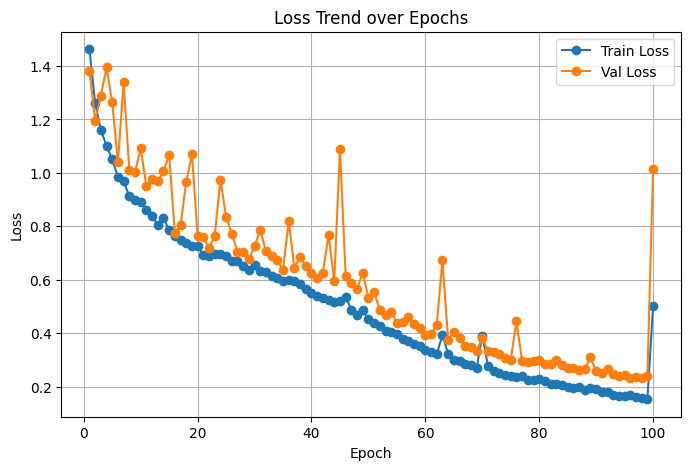

In [ ]:
import re
import matplotlib.pyplot as plt

log_file = "/content/drive/MyDrive/Colab Notebooks/2025/스마트팜창의설계/CityCode/epoch.txt"  # txt 붙여넣은 파일

train_loss = []
val_loss = []

with open(log_file, 'r') as f:
    lines = f.readlines()

for line in lines:
    # Train loss
    m1 = re.search(r"Train loss:\s*([0-9.]+)", line)
    # Val loss
    m2 = re.search(r"Val\s+loss:\s*([0-9.]+)", line)

    if m1:
        train_loss.append(float(m1.group(1)))
    if m2:
        val_loss.append(float(m2.group(1)))

epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Trend over Epochs")
plt.legend()
plt.grid(True)
plt.show()
